In [1]:
import numpy as np 
import pandas as pd 
from scipy import stats
import sklearn as sk 
import matplotlib as plot
from mpl_toolkits.mplot3d import Axes3D
import requests as req 
import json
import unidecode
from nba_api.stats.endpoints import leagueseasonmatchups
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from nba_api.stats.static import players

In [2]:
team_map = {"ATL" : "Atlanta Hawks", "BKN" : "Brooklyn Nets", "BOS": "Boston Celtics", "CHA" : "Charlotte Hornets", "CHI" : "Chicago Bulls", "CLE" : "Cleveland Cavaliers", "DAL" : "Dallas Mavericks", "DEN" : "Denver Nuggets", "DET" : "Detroit Pistons", "GSW" : "Golden State Warriors", "HOU" : "Houston Rockets", "IND" : "Indiana Pacers", "LAC" : "Los Angeles Clippers", "LAL" : "Los Angeles Lakers", "MEM" : "Memphis Grizzlies", "MIA" : "Miami Heat", "MIL" : "Milwaukee Bucks", "MIN" : "Minnesota Timberwolves","NOP" : "New Orleans Pelicans", "NYK" : "New York Knicks", "OKC" : "Oklahoma City Thunder", "ORL" : "Orlando Magic", "PHI" : "Philadelphia 76ers", "PHX" : "Phoenix Suns", "POR" : "Portland Trail Blazers", "SAC" : "Sacramento Kings", "SAS" : "San Antonio Spurs", "TOR" : "Toronto Raptors", "UTA" : "Utah Jazz", "WAS" : "Washington Wizards"}

df_team = pd.read_csv('../data/teams_stats/2019-20_nba_teams.csv')
df_player = pd.read_csv('../data/player_stats/2019-20_nba_players_new.csv')

df_playerid = pd.read_csv('../data/nba_api/all_players.csv')
df_playerid = df_playerid[['id', 'full_name']]

def stripPeriods(s):
    return s.replace('.', '')

df_playerid['full_name'] = df_playerid['full_name'].apply(stripPeriods)


In [3]:
df_playerid.head()

,id,full_name
0,76001,Alaa Abdelnaby
1,76002,Zaid Abdul-Aziz
2,76003,Kareem Abdul-Jabbar
3,51,Mahmoud Abdul-Rauf
4,1505,Tariq Abdul-Wahad


In [4]:
df_player.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Steven Adams/adamsst01,C,26,OKC,63,63,1680,283,478,...,0.582,207,376,583,146,51,67,94,122,684
1,2,Bam Adebayo/adebaba01,PF,22,MIA,72,72,2417,440,790,...,0.691,176,559,735,368,82,93,204,182,1146
2,3,LaMarcus Aldridge/aldrila01,C,34,SAS,53,53,1754,391,793,...,0.827,103,289,392,129,36,87,74,128,1001
3,4,Kyle Alexander/alexaky01,C,23,MIA,2,0,13,1,2,...,NaN,2,1,3,0,0,0,1,1,2
4,5,Nickeil Alexander-Walker/alexani01,SG,21,NOP,47,1,591,98,266,...,0.676,9,75,84,89,17,8,54,57,267


In [5]:
def stripAsterisk(s):
    if s[-1] == '*':
        return s[0:-1]
    else:
        return s

df_team['Team'] = df_team['Team'].apply(stripAsterisk)
df_team = df_team.dropna()
df_team.head()

,Rk,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,PTSA
0,1.0,Dallas Mavericks,75,18175,3124,6772,0.461,1136,3095,0.367,...,791,2729,3520,1849,460,363,953,1462,8776,8405
1,2.0,Milwaukee Bucks,73,17595,3160,6638,0.476,1007,2840,0.355,...,691,3083,3774,1889,526,429,1102,1431,8663,7927
2,3.0,Portland Trail Blazers,74,17835,3122,6749,0.463,952,2525,0.377,...,754,2599,3353,1525,465,451,946,1606,8508,8593
3,4.0,Houston Rockets,72,17380,2936,6512,0.451,1126,3261,0.345,...,704,2484,3188,1557,627,371,1057,1566,8482,8269
4,5.0,Los Angeles Clippers,72,17380,2992,6425,0.466,895,2410,0.371,...,767,2664,3431,1708,511,338,1051,1594,8377,7913


In [6]:
def nameOnly(s):
    new_s = s.split('/')
    return new_s[0]

df_player['Player'] = df_player['Player'].apply(nameOnly)
df_player.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Steven Adams,C,26,OKC,63,63,1680,283,478,...,0.582,207,376,583,146,51,67,94,122,684
1,2,Bam Adebayo,PF,22,MIA,72,72,2417,440,790,...,0.691,176,559,735,368,82,93,204,182,1146
2,3,LaMarcus Aldridge,C,34,SAS,53,53,1754,391,793,...,0.827,103,289,392,129,36,87,74,128,1001
3,4,Kyle Alexander,C,23,MIA,2,0,13,1,2,...,NaN,2,1,3,0,0,0,1,1,2
4,5,Nickeil Alexander-Walker,SG,21,NOP,47,1,591,98,266,...,0.676,9,75,84,89,17,8,54,57,267


In [7]:
df_player = df_player.drop_duplicates(subset="Player", keep="last")

df_player['ID'] = 0

for index, row in df_player.iterrows():
    player = unidecode.unidecode(row['Player']).replace('.', '')
    result = df_playerid[df_playerid['full_name'].str.match(player)]
    if not result.empty:
        df_player.at[index,'ID'] = int(result['id'])

print(len(df_player))

df_player = df_player[df_player['ID'] != 0]

print(len(df_player))

df_player.to_csv('suffering.csv')


529
518


In [8]:
# higher ortg is better
def assignORtg(row):
    FGA = row['FGA']
    ORB = row['ORB']
    TOV = row['TOV']
    FTA = row['FTA']

    TotalP = FGA - ORB + TOV + (0.4 * FTA)

    PTS = row['PTS']

    return (PTS/TotalP) * 100

# Lower drtg is better
def assignDRtg(row):
    FGA = row['FGA']
    ORB = row['ORB']
    TOV = row['TOV']
    FTA = row['FTA']

    TotalP = FGA - ORB + TOV + (0.4 * FTA)

    PTSA = row['PTSA']

    return (PTSA/TotalP) * 100

# def assignNRtg(row):
#     return row['ORTG'] - row['DRTG']


df_team['ORTG'] = df_team.apply(assignORtg, axis=1)
df_team['DRTG'] = df_team.apply(assignDRtg, axis=1)
# df_team['NRTG'] = df_team.apply(assignNRtg, axis=1)
df_team.sort_values(by=['ORTG']).head()

,Rk,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,...,TRB,AST,STL,BLK,TOV,PF,PTS,PTSA,ORTG,DRTG
28,29.0,Golden State Warriors,65,15725,2510,5730,0.438,678,2032,0.334,...,2785,1663,534,299,969,1304,6912,7478,103.839913,112.343008
25,26.0,New York Knicks,66,15965,2638,5896,0.447,631,1872,0.337,...,3069,1456,504,313,946,1464,6983,7409,104.739763,111.129444
29,30.0,Charlotte Hornets,65,15750,2425,5586,0.434,785,2231,0.352,...,2781,1549,428,268,949,1223,6687,7126,104.772499,111.650790
27,28.0,Chicago Bulls,65,15675,2573,5762,0.447,793,2282,0.348,...,2721,1510,652,265,1005,1417,6945,7145,104.912535,107.933774
22,23.0,Atlanta Hawks,67,16280,2723,6067,0.449,805,2416,0.333,...,2898,1605,523,341,1086,1548,7488,8022,105.192178,112.693864


In [9]:
def assignOffensivePercentile(row):
    ortgs = np.array(df_team['ORTG'])
    return stats.percentileofscore(ortgs, row['ORTG'])

def assignDefensivePercentile(row):
    drtgs = np.array(df_team['DRTG'])
    drtgs *= -1
    
    return stats.percentileofscore(drtgs, row['DRTG'] * -1)

df_team['ORTGP'] = df_team.apply(assignOffensivePercentile, axis=1)
df_team['DRTGP'] = df_team.apply(assignDefensivePercentile, axis=1)

In [10]:
df_team.head()

,Rk,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,...,STL,BLK,TOV,PF,PTS,PTSA,ORTG,DRTG,ORTGP,DRTGP
0,1.0,Dallas Mavericks,75,18175,3124,6772,0.461,1136,3095,0.367,...,460,363,953,1462,8776,8405,114.736952,109.886518,100.000000,46.666667
1,2.0,Milwaukee Bucks,73,17595,3160,6638,0.476,1007,2840,0.355,...,526,429,1102,1431,8663,7927,111.507272,102.033724,90.000000,100.000000
2,3.0,Portland Trail Blazers,74,17835,3122,6749,0.463,952,2525,0.377,...,465,451,946,1606,8508,8593,112.038768,113.158103,93.333333,6.666667
3,4.0,Houston Rockets,72,17380,2936,6512,0.451,1126,3261,0.345,...,627,371,1057,1566,8482,8269,111.379573,108.582609,80.000000,56.666667
4,5.0,Los Angeles Clippers,72,17380,2992,6425,0.466,895,2410,0.371,...,511,338,1051,1594,8377,7913,112.192966,105.978625,96.666667,86.666667


In [11]:
teamAndWhatTheyAreBadAt = {}
for i,j in df_team.iterrows():
    team = j['Team']
    if team not in teamAndWhatTheyAreBadAt:
        offPercentile = j['ORTGP']
        defPercentile = j['DRTGP']
        if offPercentile > defPercentile:
            teamAndWhatTheyAreBadAt[team] = 'defense'
        else:
            teamAndWhatTheyAreBadAt[team] = 'offense'

In [12]:
df_player.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ID
0,1,Steven Adams,C,26,OKC,63,63,1680,283,478,...,207,376,583,146,51,67,94,122,684,203500
1,2,Bam Adebayo,PF,22,MIA,72,72,2417,440,790,...,176,559,735,368,82,93,204,182,1146,1628389
2,3,LaMarcus Aldridge,C,34,SAS,53,53,1754,391,793,...,103,289,392,129,36,87,74,128,1001,200746
3,4,Kyle Alexander,C,23,MIA,2,0,13,1,2,...,2,1,3,0,0,0,1,1,2,1629734
4,5,Nickeil Alexander-Walker,SG,21,NOP,47,1,591,98,266,...,9,75,84,89,17,8,54,57,267,1629638


In [13]:
df_player = df_player[df_player['G'] >= 30]
print(len(df_player))

318


In [14]:
df_great_dataset = pd.read_csv('GreatData.csv')
print(len(df_great_dataset))

529


In [15]:
def assignPlayerOffRtg(row):
    curPlayerID = row['ID']
    try:
        getPlayersMoreData = df_great_dataset[df_great_dataset['PLAYER_ID'] == curPlayerID]
        if len(getPlayersMoreData) > 0:
            return float(getPlayersMoreData['OFF_RATING'])
        else:
            return float(-24780.0)
    except:
        return float(-24780.0)
        

def assignPlayerDefRtg(row):
    curPlayerID = row['ID']
    try:
        getPlayersMoreData = df_great_dataset[df_great_dataset['PLAYER_ID'] == curPlayerID]
        if len(getPlayersMoreData) > 0:
            return float(getPlayersMoreData['DEF_RATING'])
        else:
            return float(-24780.0)
    except:
        return float(-24780.0)

In [16]:
df_player['ORtg'] = df_player.apply(assignPlayerOffRtg, axis=1)
df_player['DRtg'] = df_player.apply(assignPlayerDefRtg, axis=1)

In [17]:
len(df_player)

318

In [18]:
df_player = df_player[(df_player['ORtg'] != -24780.0) & (df_player['DRtg'] != -24780.0)]
print(len(df_player))

318


In [19]:
df_player.sort_values(by='ORtg', ascending=True).head(10)

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,TRB,AST,STL,BLK,TOV,PF,PTS,ID,ORtg,DRtg
98,81,Deonte Burton,SF,26,OKC,39,0,356,43,125,...,57,17,7,10,19,34,104,1629126,91.3,104.1
230,177,Brandon Goodwin,PG,24,ATL,34,1,430,76,190,...,72,51,12,4,29,43,206,1629164,94.5,108.2
188,143,Carsen Edwards,SG,21,BOS,37,0,351,42,128,...,47,24,12,4,15,34,121,1629035,94.9,100.4
493,401,Theo Pinson,SG,24,BRK,33,0,365,45,155,...,54,56,17,4,33,35,120,1629033,95.1,99.7
553,455,Dennis Smith Jr.,PG,22,NYK,34,3,537,72,211,...,78,98,28,8,58,65,187,1628372,95.7,112.8
322,253,Ty Jerome,SG,22,PHO,31,0,328,38,113,...,46,44,15,3,18,29,102,1629660,97.4,110.9
318,249,Justin James,SF,23,SAC,36,0,232,35,84,...,32,18,6,9,8,17,89,1629713,97.8,100.2
640,519,D.J. Wilson,PF,23,MIL,37,1,363,52,132,...,92,25,3,5,19,33,133,1628391,98.4,104.7
48,39,DeAndre' Bembry,SG,25,ATL,43,4,915,104,228,...,152,81,55,19,60,84,249,1627761,98.9,110.6
134,105,Chris Clemons,SG,22,HOU,33,0,291,57,142,...,30,27,9,6,19,26,161,1629598,98.9,107.7


In [20]:
df_player.sort_values(by='ORtg', ascending=True).tail(10)

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,TRB,AST,STL,BLK,TOV,PF,PTS,ID,ORtg,DRtg
608,495,Kemba Walker,PG,29,BOS,56,56,1742,378,889,...,217,268,48,28,117,91,1145,202689,115.2,108.1
376,297,Damian Lillard,PG,29,POR,66,66,2474,624,1349,...,284,530,70,22,194,114,1978,203081,115.7,114.3
391,312,Boban Marjanović,C,31,DAL,44,5,422,121,211,...,197,20,8,10,30,56,289,1626246,116.0,110.5
256,197,Tim Hardaway Jr.,SG,27,DAL,71,58,2091,384,884,...,232,137,41,5,69,125,1121,203501,116.0,110.1
208,157,Dorian Finney-Smith,PF,26,DAL,71,68,2120,243,522,...,405,114,45,39,69,178,678,1627827,116.1,109.5
503,411,Kristaps Porziņģis,C,24,DAL,57,57,1814,398,932,...,540,102,41,115,92,185,1164,204001,116.1,109.3
504,412,Dwight Powell,C,28,DAL,40,37,1061,146,229,...,227,59,34,22,36,102,376,203939,116.3,107.4
177,134,Luka Dončić,PG,20,DAL,61,61,2047,581,1255,...,573,538,62,14,260,153,1759,1629029,116.7,111.4
373,294,Kawhi Leonard,SF,28,LAC,57,57,1848,532,1133,...,402,280,103,33,149,113,1543,202695,116.9,104.7
220,167,Danilo Gallinari,PF,31,OKC,62,62,1834,358,817,...,322,119,42,5,76,75,1160,201568,116.9,111.2


In [21]:
df_player.sort_values(by='DRtg', ascending=True).head(10)

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,TRB,AST,STL,BLK,TOV,PF,PTS,ID,ORtg,DRtg
12,13,Giannis Antetokounmpo,PF,25,MIL,63,63,1917,685,1238,...,856,354,61,66,230,195,1857,203507,112.8,97.4
399,320,Wesley Matthews,SG,33,MIL,67,67,1635,167,422,...,166,92,38,9,43,103,494,202083,110.5,98.3
186,141,Jared Dudley,PF,34,LAL,45,1,364,24,60,...,52,28,15,3,8,41,68,201162,101.7,98.4
223,170,Marc Gasol,C,35,TOR,44,43,1161,119,279,...,275,147,34,38,59,124,331,201188,109.0,98.9
176,133,Donte DiVincenzo,SG,23,MIL,66,24,1520,232,510,...,318,154,85,20,90,113,610,1628978,111.9,99.6
266,205,Shaquille Harrison,SG,26,CHI,43,10,484,77,165,...,86,49,34,19,19,55,209,1627885,106.5,99.7
493,401,Theo Pinson,SG,24,BRK,33,0,365,45,155,...,54,56,17,4,33,35,120,1629033,95.1,99.7
379,300,Brook Lopez,C,31,MIL,68,67,1817,292,671,...,312,99,46,163,70,163,813,201572,112.2,100.1
318,249,Justin James,SF,23,SAC,36,0,232,35,84,...,32,18,6,9,8,17,89,1629713,97.8,100.2
188,143,Carsen Edwards,SG,21,BOS,37,0,351,42,128,...,47,24,12,4,15,34,121,1629035,94.9,100.4


In [22]:
df_player.sort_values(by='DRtg', ascending=True).tail(10)

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,TRB,AST,STL,BLK,TOV,PF,PTS,ID,ORtg,DRtg
381,302,Kevin Love,PF,31,CLE,56,56,1780,327,727,...,547,178,33,19,140,90,987,201567,107.4,115.4
582,477,Karl-Anthony Towns,C,24,MIN,35,35,1187,316,622,...,378,153,33,42,110,117,926,1626157,113.9,115.4
469,379,Jahlil Okafor,C,24,NOP,30,9,467,101,162,...,127,37,7,22,38,67,243,1626143,105.7,115.7
90,77,Thomas Bryant,C,22,WAS,46,36,1147,243,418,...,331,83,25,49,53,103,609,1628418,109.4,116.0
646,525,Trae Young,PG,21,ATL,60,60,2120,546,1249,...,255,560,65,8,289,104,1778,1629027,111.2,116.1
250,193,Rui Hachimura,PF,21,WAS,48,48,1444,254,545,...,294,87,37,8,53,105,649,1629060,108.5,116.7
543,445,Collin Sexton,PG,21,CLE,65,65,2143,513,1086,...,204,192,65,7,158,142,1349,1629012,107.8,117.0
335,262,Damian Jones,C,24,ATL,55,27,887,121,178,...,206,35,26,40,28,149,306,1627745,104.7,117.3
40,35,Bradley Beal,SG,26,WAS,57,57,2053,593,1303,...,242,347,71,23,194,126,1741,203078,113.1,117.6
570,468,Isaiah Thomas,PG,30,WAS,40,37,925,174,426,...,68,146,13,6,77,77,488,202738,109.8,120.2


In [23]:
replaceDefenseDict = {}
replaceOffenseDict = {}
for i in teamAndWhatTheyAreBadAt:
    teamKey = i
    vals = list(team_map.values())
    valIdx = vals.index(teamKey)
    teamVal = list(team_map.keys())[valIdx]
    badAt = teamAndWhatTheyAreBadAt[i]
    
    df_players_in_team = df_player[df_player['Tm'].str.match(teamVal)]

    if teamAndWhatTheyAreBadAt[i] == 'defense':
        playersInAteam = df_players_in_team.sort_values(by='DRtg', ascending=True)
        if len(playersInAteam) > 0:
            worstDefensivePlayer = playersInAteam.iloc[-1]
            hisName = worstDefensivePlayer['Player']
            hisOrtg = worstDefensivePlayer['ORtg']
            hisDrtg = worstDefensivePlayer['DRtg']
            hisPos = worstDefensivePlayer['Pos']
            hisTeam = worstDefensivePlayer['Tm']

            threshold = 1.5
            # lower defensive rating is better so doing `<`
            getPossReplacements = df_player[(df_player['ORtg'] <= hisOrtg + threshold) &
                                            (df_player['ORtg'] >= hisOrtg - threshold) &
                                            (df_player['DRtg'] < hisDrtg)]
            getPossReplacements = getPossReplacements[(getPossReplacements['Pos'] == hisPos) &
                                                     (getPossReplacements['Tm'] != hisTeam)]
            
            possReplNames = getPossReplacements['Player'].tolist()[:3]
            if hisName not in replaceDefenseDict:
                replaceDefenseDict[hisName] = possReplNames
    else:
        playersInAteam = df_players_in_team.sort_values(by='ORtg', ascending=False)
        if len(playersInAteam) > 0:
            worstOffensivePlayer = playersInAteam.iloc[-1]
            hisName = worstOffensivePlayer['Player']
            hisOrtg = worstOffensivePlayer['ORtg']
            hisDrtg = worstOffensivePlayer['DRtg']
            hisPos = worstOffensivePlayer['Pos']
            hisTeam = worstOffensivePlayer['Tm']
            
            threshold = 2.1
            getPossReplacements = df_player[(df_player['DRtg'] <= hisDrtg + threshold) &
                                            (df_player['DRtg'] >= hisDrtg - threshold) &
                                            (df_player['ORtg'] > hisOrtg)]
            getPossReplacements = getPossReplacements[(getPossReplacements['Pos'] == hisPos) &
                                                     (getPossReplacements['Tm'] != hisTeam)]

            possReplNames = getPossReplacements['Player'].tolist()[:3]
            if hisName not in replaceOffenseDict:
                replaceOffenseDict[hisName] = possReplNames

In [24]:
replaceDefenseDict

{'Justin Jackson': ['Bam Adebayo', 'Giannis Antetokounmpo', 'Anthony Davis'],
 'Damian Lillard': ['Patrick Beverley', 'Luka Dončić', 'Kemba Walker'],
 'Austin Rivers': ['Jaylen Brown', 'Terence Davis', 'Donte DiVincenzo'],
 'Landry Shamet': ['Avery Bradley', 'Jaylen Brown', 'Terence Davis'],
 'Jahlil Okafor': ['Wendell Carter Jr.', 'Joel Embiid', 'Harry Giles'],
 'Isaiah Thomas': ['Lonzo Ball', 'Alex Caruso', 'Mike Conley'],
 'Derrick Jones Jr.': ['OG Anunoby', 'Mikal Bridges', 'Joe Harris'],
 'Torrey Craig': ['Isaac Bonga', 'Terrance Ferguson', 'Evan Fournier'],
 'Bryn Forbes': ['Bogdan Bogdanović',
  'Dillon Brooks',
  'Michael Carter-Williams'],
 'Jordan Clarkson': ['Marco Belinelli', 'Bogdan Bogdanović', 'Avery Bradley'],
 'Harry Giles': ['Joel Embiid', 'Jaxson Hayes', 'Frank Kaminsky'],
 'Damian Jones': ['Mo Bamba', 'Bismack Biyombo', 'Wendell Carter Jr.'],
 'Collin Sexton': ['Malcolm Brogdon', 'Jevon Carter', 'Quinn Cook']}

In [25]:
replaceOffenseDict

{'D.J. Wilson': ['Anthony Davis', 'JaMychal Green', 'Rondae Hollis-Jefferson'],
 'Kyle Anderson': ['OG Anunoby', 'Will Barton', 'Isaac Bonga'],
 'Carsen Edwards': ['Donte DiVincenzo', 'Shaquille Harrison', 'Theo Pinson'],
 'Matt Thomas': ['Pat Connaughton', 'Shaquille Harrison', 'Romeo Langford'],
 'Raul Neto': ['Eric Bledsoe', 'Alex Caruso', 'Quinn Cook'],
 'Jared Dudley': ['Giannis Antetokounmpo'],
 'Goga Bitadze': ['Mo Bamba', 'Chris Boucher', 'Wendell Carter Jr.'],
 'Deonte Burton': ['Kyle Anderson', 'OG Anunoby', 'Gordon Hayward'],
 'Khem Birch': ['Jarrett Allen', 'Deandre Ayton', 'Bismack Biyombo'],
 'Kelan Martin': ['OG Anunoby', 'Sterling Brown', 'Hamidou Diallo'],
 'Thon Maker': ['LaMarcus Aldridge', 'Aron Baynes', 'Bismack Biyombo'],
 'Dennis Smith Jr.': ['Luka Dončić', "De'Aaron Fox", "Devonte' Graham"],
 'Denzel Valentine': ['Kyle Anderson', 'OG Anunoby', 'Paul George'],
 'Ky Bowman': ['Lonzo Ball', 'Mike Conley', 'Spencer Dinwiddie']}

In [26]:
import pickle
f = open("outputreplaceDef.pkl","wb")
pickle.dump(replaceDefenseDict,f)
f.close()
f = open("outputreplaceOff.pkl","wb")
pickle.dump(replaceOffenseDict,f)
f.close()

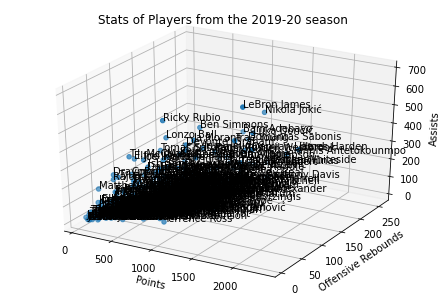

In [27]:
# Graph of players with points, offensive rebounds, and assists
X = [x for x in df_player["PTS"]]
Y = [x for x in df_player["ORB"]]
Z = [x for x in df_player["AST"]]

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(X, Y, Z)
ax.set_xlabel("Points")
ax.set_ylabel("Offensive Rebounds")
ax.set_zlabel("Assists")
ax.set_title("Stats of Players from the 2019-20 season")

for X,Y,Z,name in zip(X,Y,Z,df_player["Player"]):
    ax.text(X,Y,Z,name)

plt.show()

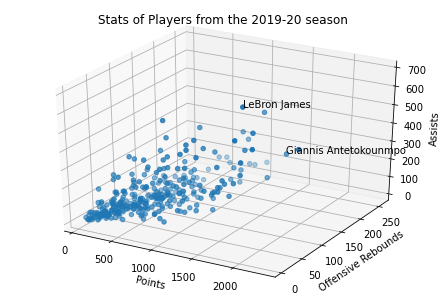

In [28]:
# Graph of players with points, offensive rebounds, and assists
X = [x for x in df_player["PTS"]]
Y = [x for x in df_player["ORB"]]
Z = [x for x in df_player["AST"]]

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(X, Y, Z)
ax.set_xlabel("Points")
ax.set_ylabel("Offensive Rebounds")
ax.set_zlabel("Assists")
ax.set_title("Stats of Players from the 2019-20 season")

for X,Y,Z,name in zip(X,Y,Z,df_player["Player"]):
    if name == 'LeBron James':
        ax.text(X,Y,Z,name)
    if name == 'Giannis Antetokounmpo':
        ax.text(X,Y,Z,name)

plt.show()

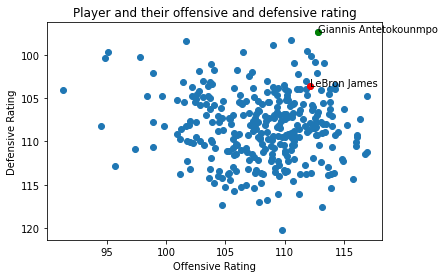

In [29]:
# graph of player and their offensive and defensive rating
X = [x for x in df_player["ORtg"]]
Y = [x for x in df_player["DRtg"]]

fig = plt.figure()

plt.scatter(X, Y)
plt.gca().invert_yaxis()
plt.xlabel("Offensive Rating")
plt.ylabel("Defensive Rating")
plt.title("Player and their offensive and defensive rating")

for X,Y,name in zip(X,Y,df_player["Player"]):
    if name == 'LeBron James':
        plt.annotate(name, (X, Y))
        plt.scatter(X, Y, color="red")
    if name == 'Giannis Antetokounmpo':
        plt.annotate(name, (X, Y))
        plt.scatter(X, Y, color="green")

plt.show()

In [30]:
import scipy as sp

Low r-value shows no correlation between ORtg and DRtg: 0.08395651405937316


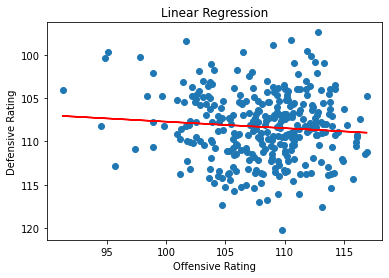

In [31]:
X = [x for x in df_player["ORtg"]]
Y = [x for x in df_player["DRtg"]]

linreg = sp.stats.linregress(X, Y)
y_new = [linreg.slope * x + linreg.intercept for x in X]

plt.scatter(X, Y)
plt.gca().invert_yaxis()
plt.plot(X, y_new, 'r')
plt.title("Linear Regression")
plt.xlabel("Offensive Rating")
plt.ylabel("Defensive Rating")
print("Low r-value shows no correlation between ORtg and DRtg: {}".format(linreg.rvalue))
plt.show()

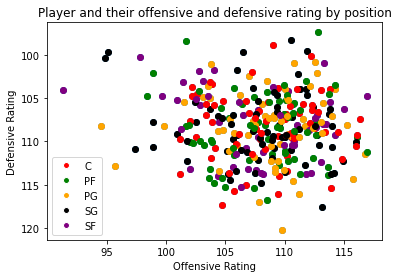

In [32]:
# offensive and defensive rating by position (diff color per position)
X = [x for x in df_player["ORtg"]]
Y = [x for x in df_player["DRtg"]]

fig, ax = plt.subplots()

plt.scatter(X, Y)
plt.gca().invert_yaxis()
plt.xlabel("Offensive Rating")
plt.ylabel("Defensive Rating")
plt.title("Player and their offensive and defensive rating by position")

for X,Y,pos in zip(X,Y,df_player["Pos"]):
    if pos == 'C':
        plt.scatter(X, Y, color="red")
    if pos == 'PF':
        plt.scatter(X, Y, color="green")
    if pos == 'PG':
        plt.scatter(X, Y, color="orange")
    if pos == 'SG':
        plt.scatter(X, Y, color="black")
    if pos == 'SF':
        plt.scatter(X, Y, color="purple")

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='C', markerfacecolor='red'),
                   Line2D([0], [0], marker='o', color='w', label='PF', markerfacecolor='green'),
                   Line2D([0], [0], marker='o', color='w', label='PG', markerfacecolor='orange'),
                   Line2D([0], [0], marker='o', color='w', label='SG', markerfacecolor='black'),
                   Line2D([0], [0], marker='o', color='w', label='SF', markerfacecolor='purple')]
ax.legend(handles=legend_elements)

plt.show()

In [33]:
# -------------------------
#    Salary Data
# -------------------------

In [34]:
df_salary = pd.read_csv('../data/salary_data/nba2019-20_salary.csv')

In [35]:
df_salary = df_salary[df_salary['season'] == '2019-2020']

In [36]:
df_salary.head()

,team,salary,player,position,season
0,Golden State Warriors,40231758,Stephen Curry,PG,2019-2020
1,Oklahoma City Thunder,38506482,Chris Paul,PG,2019-2020
2,Houston Rockets,38506482,Russell Westbrook,PG,2019-2020
3,Washington Wizards,38199000,John Wall,PG,2019-2020
4,Brooklyn Nets,38199000,Kevin Durant,SF,2019-2020


In [37]:
replaceDefenseSalaryDict = {}
replaceOffenseSalaryDict = {}

In [38]:
for player in replaceDefenseDict:
    player = unidecode.unidecode(player)
    curPlayer = df_salary[df_salary['player'] == player]
    if len(curPlayer) == 0:
        print(f"Og Player {player} not found!")
    else:
        curPlayerSalary = int(curPlayer['salary'])
        if (player, curPlayerSalary) not in replaceDefenseSalaryDict:
            replaceDefenseSalaryDict[(player, curPlayerSalary)] = []
            playersToReplaceWith = replaceDefenseDict[player]
            for otherPlayer in playersToReplaceWith:
                otherPlayer = unidecode.unidecode(otherPlayer)
                replacingPlayer = df_salary[df_salary['player'] == otherPlayer]
                if len(replacingPlayer) == 0:
                    print(f"New Player {otherPlayer} not found!")
                else:
                    replacingPlayerSalary = int(replacingPlayer['salary'])
                    replaceDefenseSalaryDict[(player, curPlayerSalary)].append((otherPlayer, replacingPlayerSalary))

In [39]:
replaceDefenseSalaryDict

{('Justin Jackson', 3280920): [('Bam Adebayo', 3454080),
  ('Giannis Antetokounmpo', 25842697),
  ('Anthony Davis', 27093018)],
 ('Damian Lillard', 29802321): [('Patrick Beverley', 12345680),
  ('Luka Doncic', 7683360),
  ('Kemba Walker', 32742000)],
 ('Austin Rivers', 2147317): [('Jaylen Brown', 6534829),
  ('Terence Davis', 898310),
  ('Donte DiVincenzo', 2905800)],
 ('Landry Shamet', 1995120): [('Avery Bradley', 4767000),
  ('Jaylen Brown', 6534829),
  ('Terence Davis', 898310)],
 ('Jahlil Okafor', 1702486): [('Wendell Carter Jr.', 5201400),
  ('Joel Embiid', 27504630),
  ('Harry Giles', 2578800)],
 ('Isaiah Thomas', 1620564): [('Lonzo Ball', 8719320),
  ('Alex Caruso', 2750000),
  ('Mike Conley', 32511624)],
 ('Derrick Jones Jr.', 1645357): [('OG Anunoby', 2281800),
  ('Mikal Bridges', 4161000),
  ('Joe Harris', 7666667)],
 ('Torrey Craig', 2000000): [('Isaac Bonga', 1416842),
  ('Terrance Ferguson', 2475840),
  ('Evan Fournier', 17150000)],
 ('Bryn Forbes', 2875000): [('Bogdan Bog

In [40]:
for player in replaceOffenseDict:
    player = unidecode.unidecode(player)
    curPlayer = df_salary[df_salary['player'] == player]
    if len(curPlayer) == 0:
        print(f"Og Player {player} not found!")
    else:
        curPlayerSalary = int(curPlayer['salary'])
        if (player, curPlayerSalary) not in replaceOffenseSalaryDict:
            replaceOffenseSalaryDict[(player, curPlayerSalary)] = []
            playersToReplaceWith = replaceOffenseDict[player]
            for otherPlayer in playersToReplaceWith:
                otherPlayer = unidecode.unidecode(otherPlayer)
                replacingPlayer = df_salary[df_salary['player'] == otherPlayer]
                if len(replacingPlayer) == 0:
                    print(f"New Player {otherPlayer} not found!")
                else:
                    replacingPlayerSalary = int(replacingPlayer['salary'])
                    replaceOffenseSalaryDict[(player, curPlayerSalary)].append((otherPlayer, replacingPlayerSalary))

In [41]:
replaceOffenseSalaryDict

{('D.J. Wilson', 2961120): [('Anthony Davis', 27093018),
  ('JaMychal Green', 4767000),
  ('Rondae Hollis-Jefferson', 2500000)],
 ('Kyle Anderson', 9073050): [('OG Anunoby', 2281800),
  ('Will Barton', 12776786),
  ('Isaac Bonga', 1416842)],
 ('Carsen Edwards', 1228026): [('Donte DiVincenzo', 2905800),
  ('Shaquille Harrison', 1620564),
  ('Theo Pinson', 1445697)],
 ('Matt Thomas', 898310): [('Pat Connaughton', 1723050),
  ('Shaquille Harrison', 1620564),
  ('Romeo Langford', 3458400)],
 ('Raul Neto', 1620564): [('Eric Bledsoe', 15625000),
  ('Alex Caruso', 2750000),
  ('Quinn Cook', 3000000)],
 ('Jared Dudley', 1620564): [('Giannis Antetokounmpo', 25842697)],
 ('Goga Bitadze', 2816760): [('Mo Bamba', 5697600),
  ('Chris Boucher', 1588231),
  ('Wendell Carter Jr.', 5201400)],
 ('Deonte Burton', 1416852): [('Kyle Anderson', 9073050),
  ('OG Anunoby', 2281800),
  ('Gordon Hayward', 32700690)],
 ('Khem Birch', 3000000): [('Jarrett Allen', 2376840),
  ('Deandre Ayton', 9562920),
  ('Bismac

In [42]:
# raise SystemExit("Stop right here!")

In [43]:
# -------------------------
#     K-MEANS CLUSTERING
# -------------------------

In [44]:
def pca(m, dims):
    k = min(m.shape[-1], dims)
    m_t = m.T
    mm_t = np.matmul(m, m_t)
    m_tm = np.matmul(m_t, m)
    matrix = mm_t if mm_t.shape[0] < m_tm.shape[0] else m_tm

    eigvals, eigvecs = np.linalg.eig(matrix)
    e = np.array([x for _,x in sorted(zip(eigvals,eigvecs))[::-1]])
    ek = e[:,:k]
    me2 = np.matmul(m, ek)
    columns = [f'x{i}' for i in range(me2.shape[-1])]
    df = pd.DataFrame(me2, columns=columns)
    res = df[columns].values
    print(res)
    return res, df, columns

In [45]:
def create_cluster_data(year, dim_vals, normalize):
    stats = ['ID', 'GP','PTS','AST','STL','BLK','TOV',
                'FT%', 'FG%', 'FTA', 'FGA', 'FG3A']
    selection = np.array(list(set(stats).intersection(set(dim_vals))))
    df = pd.read_csv(f'../code/player_data.csv') # this is cleaned data, change to year later ...
    # year can be empty for now
    player_ids = df['ID'].values
    df = df[selection]
    if normalize:
        df = df[selection].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    arr = df[selection].values
    return player_ids, arr, df, selection

In [46]:
class NBACluster():
    def __init__(self, num_clusters):
        self.num_clusters = num_clusters

    def init_data_from_df(self, year, dim_vals, normalize=True):
        self.year = year
        self.dim_vals = dim_vals
        self.cols = dim_vals
        self.reduced = False
        self.names, self.x, self.df, self.ordered_dims = create_cluster_data(year, dim_vals, normalize)
        if len(self.dim_vals) > 3:
            self.x, self.df, self.ordered_dims = pca(self.x, 3)
            self.dim_vals = self.ordered_dims
            self.reduced = True
        print(f'{self.names.shape[0]} unique points, each with dimension {self.x.shape[-1]}')

    def fit(self, eps):
        pass
    
    def get_labels(self):
        return self.labels
    
    def text_display_cluster(self):
        for i,p in enumerate(self.x):
            name_obj = players.find_player_by_id(self.names[i])
            if name_obj != None:
                name = name_obj['full_name']
                print(f'{name}: Group {self.labels[i]} with centroid {self.centroids[self.labels[i]]}')

    def plot(self, disp_names=False, thresh=0.8, single_name='', interactive=False):
        self.priority_name_index = -1
        player = players.find_players_by_full_name(single_name)
        if len(player) == 1:
            self.p_id = player[0]['id']
            index = np.where(np.array(self.names)==self.p_id)
            if len(index) == 1:
                self.priority_name_index = index[0][0]
                
        self.color_labels = [f'Group {i+1}' for i in range(self.num_clusters)]
        groups = [[] for i in range(self.num_clusters)]
        group_labels = [[] for i in range(self.num_clusters)]
        for i,p in enumerate(self.x):
            groups[self.labels[i]].append(p)
            group_labels[self.labels[i]].append(self.labels[i])
        groups = np.array(groups)
        if len(self.dim_vals) == 1:
            pass
        elif len(self.dim_vals) == 2:
            fig, ax = plt.subplots()
            ax.scatter(self.x[::,0], self.x[::,1], c=self.labels)
            ax.set_xlabel(self.ordered_dims[0])
            ax.set_ylabel(self.ordered_dims[1])
            dim1_thresh = np.max(self.x[::,0]) * thresh
            dim2_thresh = np.max(self.x[::,1]) * thresh
            if disp_names:
                for i,p in enumerate(self.x):
                    if p[0] > dim1_thresh or p[1] > dim2_thresh:
                        name_obj = players.find_player_by_id(self.names[i])
                        if name_obj != None:
                            name = name_obj['full_name']
                            ax.text(p[0],p[1], name)
            for i,p in enumerate(self.x):
                if i==self.priority_name_index:
                    name_obj = players.find_player_by_id(self.names[i])
                    if name_obj != None:
                        name = name_obj['full_name']
                        ax.text(p[0],p[1], name)
        elif len(self.dim_vals) == 3:
            fig = plt.figure()
            ax = Axes3D(fig)
            ax.scatter(xs=self.x[::,0], ys=self.x[::,1], zs=self.x[::,2], c=self.labels)
            ax.set_xlabel(self.ordered_dims[0])
            ax.set_ylabel(self.ordered_dims[1])
            ax.set_zlabel(self.ordered_dims[2])
            dim1_thresh = np.max(self.x[::,0]) * thresh
            dim2_thresh = np.max(self.x[::,1]) * thresh
            dim3_thresh = np.max(self.x[::,2]) * thresh
            
            if disp_names:
                for i,p in enumerate(self.x):
                    if p[0] > dim1_thresh or p[1] > dim2_thresh or p[2] > dim3_thresh:
                        name_obj = players.find_player_by_id(self.names[i])
                        if name_obj != None:
                            name = name_obj['full_name']
                            ax.text(p[0],p[1],p[2], name)
            for i,p in enumerate(self.x):
                if i==self.priority_name_index:
                    name_obj = players.find_player_by_id(self.names[i])
                    if name_obj != None:
                        name = name_obj['full_name']
                        ax.text(p[0],p[1],p[2], name)
        is_dr = '' if not self.reduced else '-with-PCA'
        rounded_ssd = np.round(self.ssd, 4)
        title = f'{self.method}-k={self.num_clusters}-{self.cols}-{self.year}'
        plt.title(f'{title}')
#         plt.savefig(f'img/{title}')
        if interactive:
            plt.show()
        plt.close()

In [47]:
# Using Sklearn's k-means

class NBAKMeans(NBACluster):
    def fit(self, initialization, max_iter, tolerance):
        self.method = 'KM'
        self.engine = KMeans(n_clusters=self.num_clusters, init=initialization,
                                max_iter=max_iter, tol=tolerance)        
        cluster = self.engine.fit(self.x)
        self.labels = cluster.labels_
        self.centroids = cluster.cluster_centers_
        
        print(f'KMeans ran for {cluster.n_iter_} iterations with ssd {cluster.inertia_}')
        self.ssd = cluster.inertia_

In [48]:
# K-Means from scratch

class NBAKMeansSimple(NBACluster):
    def fit(self, rand_initialization, tolerance):
        self.method = 'KM-Simple-Random' if rand_initialization else 'KM-Simple-Extreme'
        cluster = self.k_means(self.num_clusters, self.df, tolerance, 
                    random=rand_initialization, cols=np.array(self.df.columns.values))
        # labels
        self.labels = cluster[0]
        self.centroids = cluster[2]
        dist = 0
        a = np.array(self.df.values)
    
        for v in range(len(a)):
            dist += self.dist(a[v], self.centroids[self.labels[v]])
        self.ssd = dist
        print(f'The mean of the whole cluster is {cluster[1]}')

    def dist(self, x1, x2):
        return np.sqrt(np.sum((x1-x2)**2))
   
    def get_extreme_points(self, k, df, cols):
        X = []
        for c in cols:
            x = df[c].values
            X.append(x)
        X = np.array(X)
        X = X.T
        
        center = []
        for i in range(X.shape[1]):
            x_bar = np.sum(X[:,i]) / len(X)
            center.append(x_bar)
            
        center = np.array(center) 
        arr = [(self.dist(center, val), val) for val in X]
        res = sorted(arr, key=lambda tup: tup[0])[::-1][:k]
        return np.array(list(np.array(res)[:,1])), X

    def update_centroids(self, points, assignments, k, feature_num):
        eps = 1e-5
        cluster_tuples = [[0 for i in range(feature_num+1)] for j in range(k)]
        for ind,val in enumerate(points):
            for i in range(feature_num):
                cluster_tuples[assignments[ind]][i] += val[i]
            cluster_tuples[assignments[ind]][-1] += 1
        centroids = [[x[i]/(x[-1]+eps) for i in range(feature_num)] for x in cluster_tuples]
        return centroids

    def update_points(self, centroids, values):
        assignments = []
        for val in values:
            lowest = np.inf
            centroid_val = 0
            for ind, ctr in enumerate(centroids):
                d = self.dist(val, ctr)
                if d < lowest:
                    lowest = d 
                    centroid_val = ind
            assignments.append(centroid_val)
        return assignments

    def init_centroids(self, k, df, random=True, other_data=None, cols=None):
        centroids = []
        if random:
            values = self.df.values
            indices = np.random.choice(list(range(len(values))), k, replace=False)
            centroids = values[indices]
        else:
            centroids, values = self.get_extreme_points(k, df, cols)
        return centroids, values

    def k_means(self, k, df, tolerance, random=True, other_data=None, cols=None, get_avg_distance=True):
        feature_num = len(cols)
        centroids, values = self.init_centroids(k, df, random, other_data=other_data, cols=cols)
        
        while True:
            assignments = self.update_points(centroids, values)
            new_centroids = self.update_centroids(values, assignments, k, feature_num)
            distance = self.dist(np.array(centroids), np.array(new_centroids))
            if distance == 0:
                break
            centroids = new_centroids
        mean = None
        if get_avg_distance:
            d = 0
            for ind,val in enumerate(values):
                d += self.dist(val, centroids[assignments[ind]])
            mean = d / len(values)
        return assignments, mean, centroids

In [49]:
nba1 = NBAKMeansSimple(3)
cols = ['PTS', 'AST', 'TOV', 'BLK']

In [50]:
nba1.init_data_from_df('2019-20', cols)

[[-5.45669641e-01 -1.96738745e-01  6.75355700e-02]
 [-1.06307394e+00 -1.44687716e-01  1.90383903e-01]
 [-6.04623150e-01 -3.18141259e-01 -4.80865277e-04]
 ...
 [-5.16433850e-04 -7.43772577e-05 -5.74477651e-04]
 [-5.44784385e-02 -1.82320650e-02 -1.24859655e-02]
 [-4.14419701e-01 -2.43352315e-01  3.16917777e-02]]
518 unique points, each with dimension 3


In [51]:
nba1.fit(True, 0.0001)

The mean of the whole cluster is 0.13465915631630734


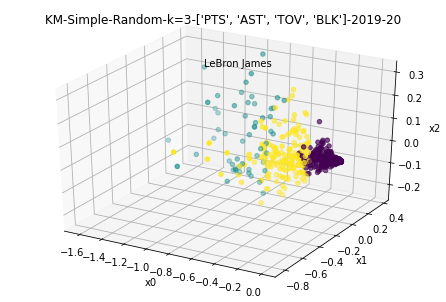

In [52]:
nba1.plot(single_name='LeBron James', disp_names=False, interactive=True)

In [53]:
nba2 = NBAKMeans(4)
cols = ['PTS', 'AST', 'TOV', 'BLK']
nba2.init_data_from_df('2019-20', cols)

[[-5.45669641e-01 -1.96738745e-01  6.75355700e-02]
 [-1.06307394e+00 -1.44687716e-01  1.90383903e-01]
 [-6.04623150e-01 -3.18141259e-01 -4.80865277e-04]
 ...
 [-5.16433850e-04 -7.43772577e-05 -5.74477651e-04]
 [-5.44784385e-02 -1.82320650e-02 -1.24859655e-02]
 [-4.14419701e-01 -2.43352315e-01  3.16917777e-02]]
518 unique points, each with dimension 3


In [54]:
nba2.fit('k-means++', 300, 0.0001)

KMeans ran for 9 iterations with ssd 11.875013597910442


In [55]:
# nba2.text_display_cluster()

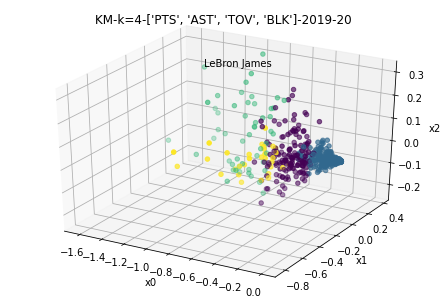

In [56]:
nba2.plot(single_name='LeBron James', disp_names=False, interactive=True)